In [39]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as cx
import plotly.express as px

sns.set_style('whitegrid')
sns.set_palette('husl')

In [40]:
ee.Initialize()
ee.Authenticate()


Successfully saved authorization token.


In [41]:
#Import train and test data
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')

In [42]:
print(train.shape)
train.head()

(1500, 4)


,ID,Lat,Lon,Target
0,ID_SJ098E7S2SY9,34.162491,70.763668,0
1,ID_CWCD60FGJJYY,32.075695,48.492047,0
2,ID_R1XF70RMVGL3,14.542826,33.313483,1
3,ID_0ZBIDY0PEBVO,14.359480,33.284108,1
4,ID_C20R2C0AYIT0,14.419128,33.528450,0


<Axes: xlabel='Lon', ylabel='Lat'>

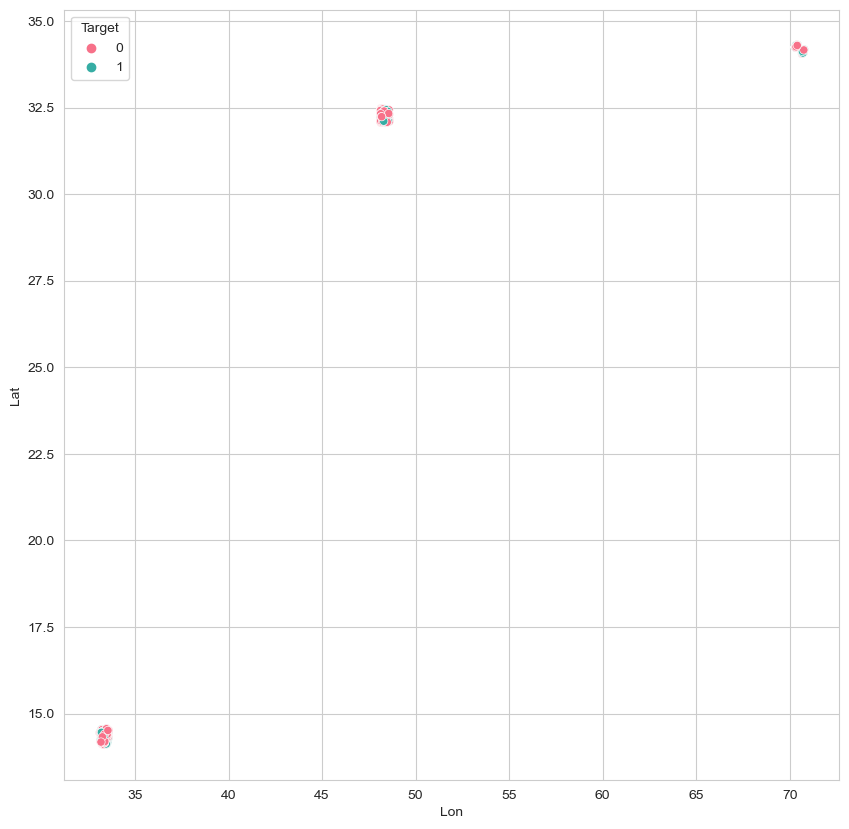

In [43]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x='Lon', y='Lat', data=train, hue='Target', palette='husl')

In [44]:
def determine_country(lat, lon) -> str:
  point = ee.Geometry.Point(lon, lat)
  country = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level0").filterBounds(point).first().get('ADM0_NAME').getInfo()
  print(country)
  return str(country)

In [45]:
import concurrent.futures as cf

def determine_country_parallel(x):
  lat, lon = x['Lat'], x['Lon']
  return determine_country(lat, lon)

with cf.ThreadPoolExecutor(12) as executor:
  results = list(executor.map(determine_country_parallel, train.to_dict('records')))

train['Country'] = results

In [46]:
# train.to_csv('data/Train_with_country.csv', index=False)
train = pd.read_csv('data/Train_with_country.csv')

In [47]:
countries = train['Country'].unique()

In [48]:
sudan_train = train[train['Country'] == 'Sudan']
iran_train = train[train['Country'] == 'Iran  (Islamic Republic of)']
afganistan_train = train[train['Country'] == 'Afghanistan']

sudan_geodata = gpd.GeoDataFrame(sudan_train, geometry=gpd.points_from_xy(sudan_train.Lon, sudan_train.Lat))
iran_geodata = gpd.GeoDataFrame(iran_train, geometry=gpd.points_from_xy(iran_train.Lon, iran_train.Lat))
afganistan_geodata = gpd.GeoDataFrame(afganistan_train, geometry=gpd.points_from_xy(afganistan_train.Lon, afganistan_train.Lat))

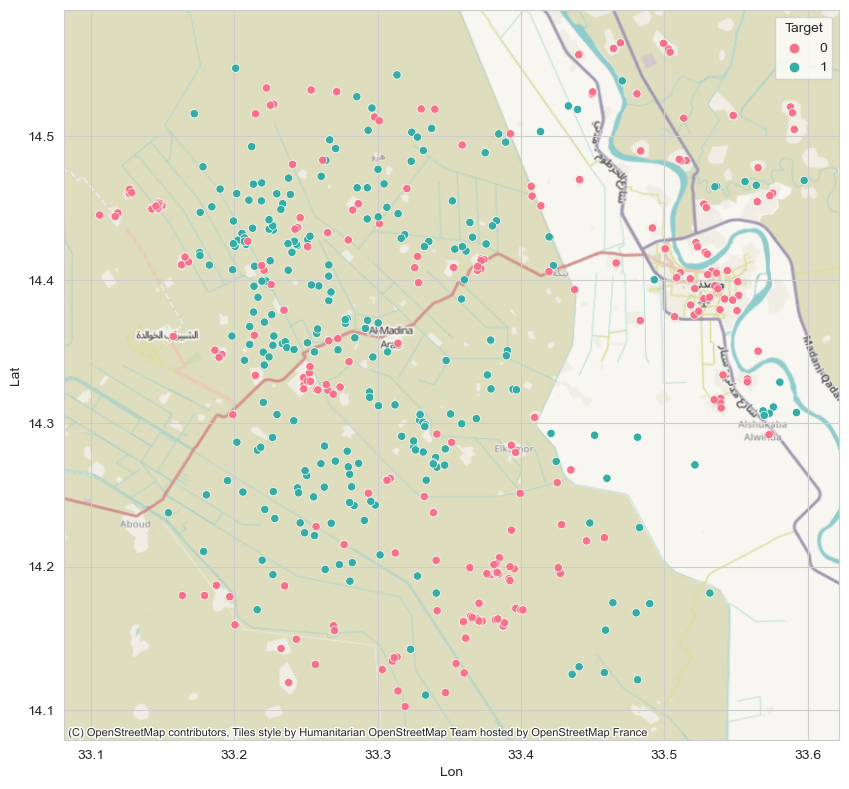

In [49]:
plt.figure(figsize=(10, 10))
plot = sns.scatterplot(x='Lon', y='Lat', data=sudan_train, hue='Target', palette='husl')
cx.add_basemap(plot, crs='EPSG:4326', source=cx.providers.OpenStreetMap.HOT)

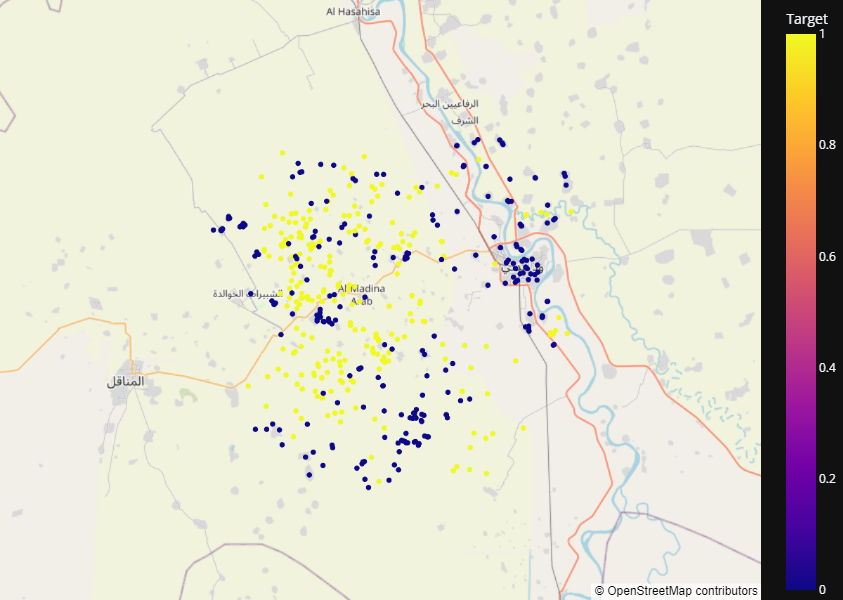

<Figure size 2000x2000 with 0 Axes>

In [50]:
plt.figure(figsize=(20, 20))

fig = px.scatter_mapbox(sudan_train, lat="Lat", lon="Lon", color="Target", zoom=9, height=600, color_discrete_sequence=['fuchsia'])
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [60]:
# Get extents of Sudan
sudan_extent = sudan_geodata.total_bounds.tolist()


# Sudan Get NDVI

In [63]:
Map = geemap.Map(center=[15.5, 30], zoom=6)

In [62]:
def mask_s2_clouds(image):
  qa = image.select('QA60')
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11
  mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  return image.updateMask(mask).divide(10000)

In [53]:
s2_collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(ee.Geometry.Rectangle(sudan_extent)).filterDate('2022-04-01', '2022-05-31').filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10).map(mask_s2_clouds)

In [66]:
vis_params = {
  'min': 0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2']
}

In [67]:
Map.addLayer(s2_collection.median(), vis_params, 'S2')

In [68]:
Map

Map(center=[15.5, 30], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…